# MMP registration and Polscope mask

In [3]:
import SimpleITK as sitk

import numpy as np
import numpy.ma as ma

from myshow import myshow

import os
import sys
PolDir = "F:/Box Sync/Research/Polarimetry/Jupyter Analysis/Polscope_BasicCorrected/"
MMPDir = "F:/Box Sync/Research/Polarimetry/Jupyter Analysis/MMP input/"
OutDir = "F:/Box Sync/Research/Polarimetry/Jupyter Analysis/Reg Mask Output/"

#module_path = os.path.abspath(os.path.join('C:/Users/mpinkert/Documents/GitHub/SimpleITK-Notebooks/Utilities/'))
#if module_path not in sys.path:
 #   sys.path.append(module_path)
    
#from downloaddata import fetch_data as fdata

# setup our plotting environment
import matplotlib.pyplot as plt
from matplotlib import gridspec

%matplotlib inline

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = fig_size[0]*2
fig_size[1] = fig_size[1]*2
plt.rcParams["figure.figsize"] = fig_size


## Utility functions

In [2]:
def polToDegree(itkImg, ceiling):
    # Change from 16 bit integer, to a degrees.
    retImg = itkImg * (ceiling/65535) * (4/549) * 90
    return retImg

In [3]:
def affine_registration(fixed_image, moving_image, fixedMask = None, movingMask = None):
    registration_method = sitk.ImageRegistrationMethod()

     # Similarity metric settings.|
    #registration_method.SetMetricAsMeanSquares()
    registration_method.SetMetricAsMattesMutualInformation()
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(1)

    registration_method.SetInterpolator(sitk.sitkLinear)

    if fixedMask:
        registration_method.SetMetricFixedMask(fixedMask)
        
    if movingMask:
        registration_method.SetMetricMovingMask(movingMask)
    
        # Optimizer settings.
    registration_method.SetOptimizerAsRegularStepGradientDescent(20.0, 0.01, 200)
    #registration_method.SetOptimizerAsOnePlusOneEvolutionary(numberOfIterations=100)
    #registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-4, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

        # Setup for the multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [16,8,4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[4,2,2,1,1])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

        #Redefining initial_transform so the function 
    transform = sitk.AffineTransform(2)
    #transform = sitk.TranslationTransform(2)
    
    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(transform)

        # Connect all of the observers so that we can perform plotting during registration.
    registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
    registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
    registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
    registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method, fixed_image, moving_image,transform))

    #affine_transform = registration_method.Execute(fixed_image,moving_image)
    #print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    #print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

    return (registration_method.Execute(fixed_image,moving_image), registration_method.GetMetricValue(), registration_method.GetOptimizerStopConditionDescription())

In [4]:
def affine_registration_fineRegister(fixed_image, moving_image, fixedMask = None, movingMask = None):
    registration_method = sitk.ImageRegistrationMethod()

     # Similarity metric settings.|
    #registration_method.SetMetricAsMeanSquares()
    registration_method.SetMetricAsMattesMutualInformation()
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(1)

    registration_method.SetInterpolator(sitk.sitkLinear)

    if fixedMask:
        registration_method.SetMetricFixedMask(fixedMask)
        
    if movingMask:
        registration_method.SetMetricMovingMask(movingMask)
    
        # Optimizer settings.
    registration_method.SetOptimizerAsRegularStepGradientDescent(5.0, 0.001, 500)
    #registration_method.SetOptimizerAsOnePlusOneEvolutionary(numberOfIterations=100)
    #registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-4, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

        # Setup for the multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[1,1])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

        #Redefining initial_transform so the function 
    transform = sitk.AffineTransform(2)
    #transform = sitk.TranslationTransform(2)
    
    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(transform)

        # Connect all of the observers so that we can perform plotting during registration.
    registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
    registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
    registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
    registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method, fixed_image, moving_image,transform))

    #affine_transform = registration_method.Execute(fixed_image,moving_image)
    #print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    #print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

    return (registration_method.Execute(fixed_image,moving_image), registration_method.GetMetricValue(), registration_method.GetOptimizerStopConditionDescription())

In [5]:
# GUI components (sliders, dropdown...).
from ipywidgets import interact

# Enable display of HTML.
from IPython.display import clear_output


# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixedITK, movingITK):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2)
    
    fixed_npa = sitk.GetArrayFromImage(fixedITK)
    moving_npa = sitk.GetArrayFromImage(movingITK)
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    plt.show()
    
# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(alpha, fixed, moving):
    img = (1.0 - alpha)*fixed + alpha*moving 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
def display_registered(fixed_image,registered_image):
    plt.imshow(sitk.GetArrayViewFromImage(registered_image), cmap=plt.cm.Reds)
    plt.hold
    plt.imshow(sitk.GetArrayViewFromImage(fixed_image),cmap=plt.cm.gray)
    
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.    
def plot_values(registration_method, fixed_image, moving_image,transform):
    global metric_values, multires_iterations
    

    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    
    alpha = 0.7
    moving_transformed = sitk.Resample(moving_image, fixed_image, transform, 
                                       sitk.sitkLinear, 0.0, 
                                       moving.GetPixelIDValue()) 
    
    #Blend the registered and fixed images                                   
    combined = (1.0 - alpha)*fixed_image + alpha*moving_transformed
    combined_eightbit = sitk.Cast(sitk.RescaleIntensity(combined), sitk.sitkUInt8)  
    
    #plot the current image
    #plt.subplots(1,2)
    fig, (ax, ax2) = plt.subplots(ncols=2)
    
    #plt.subplot(1,2,1)

    ax.imshow(sitk.GetArrayFromImage(combined_eightbit),cmap=plt.cm.gray)
    
   # plt.title(multires_iterations)
        # Plot the similarity metric values

    #plt.subplot(1,2,2)
    ax2.plot(metric_values, 'r')
    ax2.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    ax2.set_xlabel('Iteration Number',fontsize=12)
    #ax2.set_ylabel('Metric Value',fontsize=12, rotation='0')
    asp = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
    ax2.set_aspect(asp)

    plt.show()
  
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))
    
#def convertToDegrees(polImg, retCeiling)



## Read images

Read in the fixed (Polscope) and moving (MMP) images.  The Polscope images need to be converted from nanometers to degrees, to be on the same scale as the MMP images.

### WP2

In [6]:
sample = 'WP2'

fixed = polToDegree(sitk.ReadImage(PolDir + sample + '.tif', sitk.sitkFloat32),35)
moving = sitk.ReadImage(MMPDir + sample + '_MMP.tif')


# All polscope images 
fixed.SetSpacing([5.416,5.416])


#For WP2, WP5, WP9
moving.SetSpacing([5.78,5.78])

#For WP4
#moving.SetSpacing([5.72,5.72])


#moving.SetOrigin([3480,1698])
# fixed.SetOrigin([4284,2205])


## Display initial image pairs

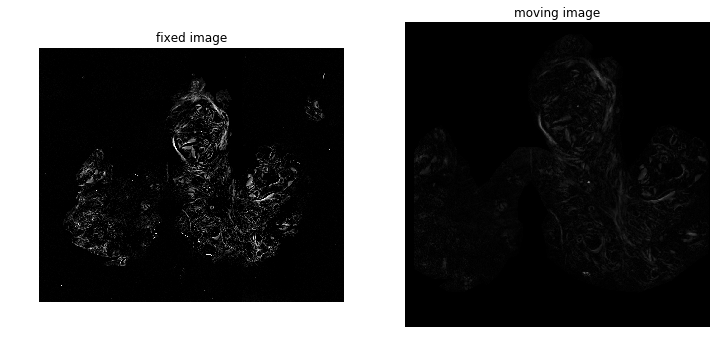

In [7]:
display_images(fixed, moving)

## Affine Registration

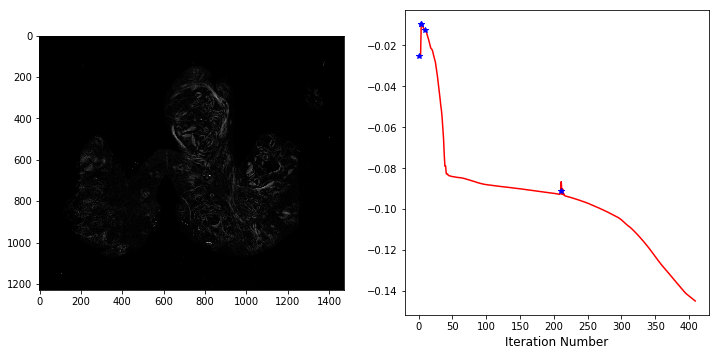

Final metric value: -0.14475748509351363
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Maximum number of iterations (200) exceeded.
itk::simple::Transform
 AffineTransform (00000280F5599640)
   RTTI typeinfo:   class itk::AffineTransform<double,2>
   Reference Count: 3
   Modified Time: 9717703
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.999985 -0.0140515 
     0.00580256 0.99993 
   Offset: [-847.547, -568.725]
   Center: [0, 0]
   Translation: [-847.547, -568.725]
   Inverse: 
     0.999934 0.0140516 
     -0.00580258 0.999989 
   Singular: 0



In [8]:

#For WP4, WP5 and WP9, the start is so far off we need to fix origin for registration. WP2[1000, 652] WP5 [2500, 2000], WP9 [2600,2600]
#moving.SetOrigin([1000,652])

(transform, metric, stop) = affine_registration(fixed, moving)
print('Final metric value: {0}'.format(metric))
print('Optimizer\'s stopping condition, {0}'.format(stop))
print(transform)
#print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
#print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))


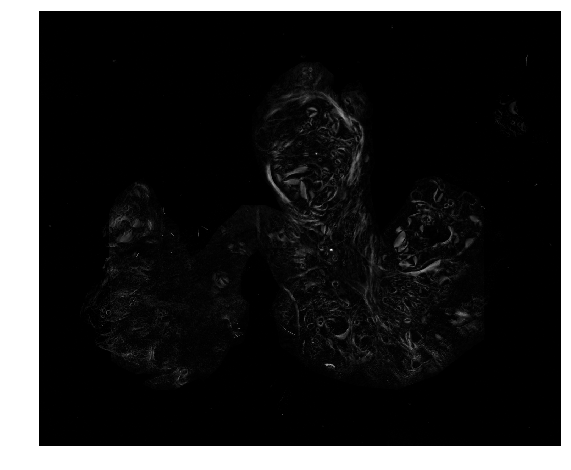

In [9]:
registered = sitk.Resample(moving, fixed, transform, sitk.sitkLinear, 0.0, moving.GetPixelID())
display_images_with_alpha(0.7,fixed, registered)


In [10]:
#maskedFixed = sitk.Mask(fixed,fixedMask)
postRegMask = registered > 0
masked_fixed_image = sitk.Mask(fixed,postRegMask)
#myshow(masked_fixed_image)

In [11]:
sitk.WriteImage(registered,os.path.join(OutDir,sample+'_RegularStepAffineReg'+'.tif'))

In [12]:
sitk.WriteImage(masked_fixed_image,os.path.join(OutDir,sample+'_maskFix_RegularStepAffineReg'+'.tif'))

## Second registration

This is a second fine-tuning registration.  Some of the registration results need a second pass

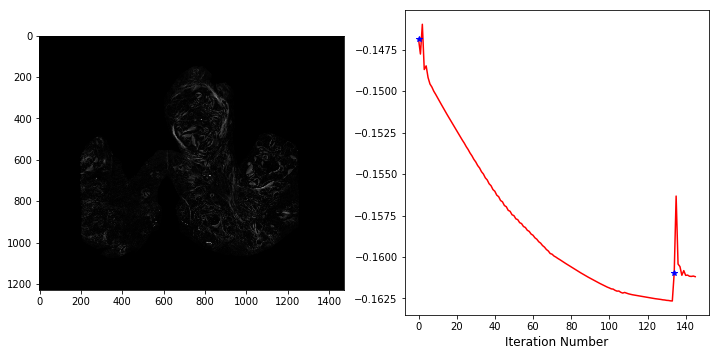

Final metric value: -0.16118745101133602
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 12 iterations. Gradient magnitude (9.56939e-05) is less than gradient magnitude tolerance (0.0001).
itk::simple::Transform
 AffineTransform (00000280F5599640)
   RTTI typeinfo:   class itk::AffineTransform<double,2>
   Reference Count: 3
   Modified Time: 9717703
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.999985 -0.0140515 
     0.00580256 0.99993 
   Offset: [-847.547, -568.725]
   Center: [0, 0]
   Translation: [-847.547, -568.725]
   Inverse: 
     0.999934 0.0140516 
     -0.00580258 0.999989 
   Singular: 0



In [13]:
(transform2, metric2, stop2) = affine_registration_fineRegister(masked_fixed_image, registered)
print('Final metric value: {0}'.format(metric2))
print('Optimizer\'s stopping condition, {0}'.format(stop2))
print(transform)

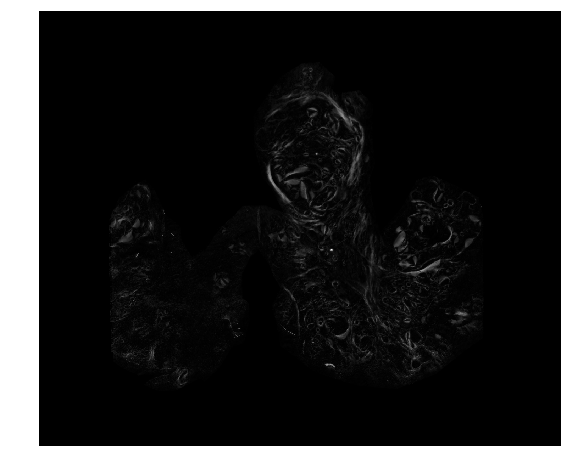

In [14]:
registered2 = sitk.Resample(registered, masked_fixed_image, transform2, sitk.sitkLinear, 0.0, moving.GetPixelID())

display_images_with_alpha(0.7,masked_fixed_image, registered2)


In [15]:
sitk.WriteImage(registered2,os.path.join(OutDir,sample+'_RegularStepAffineReg_RegToMask'+'.tif'))

# WP4

In [16]:
sample = 'WP4'

fixed = polToDegree(sitk.ReadImage(PolDir + sample + '.tif', sitk.sitkFloat32),35)
moving = sitk.ReadImage(MMPDir + sample + '_MMP.tif')


# All polscope images 
fixed.SetSpacing([5.416,5.416])


#For WP2, WP5, WP9
#moving.SetSpacing([5.78,5.78])

#For WP4
moving.SetSpacing([5.72,5.72])


#moving.SetOrigin([3480,1698])
# fixed.SetOrigin([4284,2205])


## Display initial image pairs

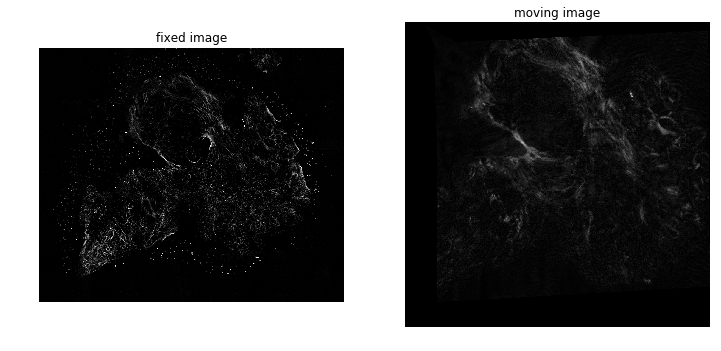

In [17]:
display_images(fixed, moving)

## Affine Registration

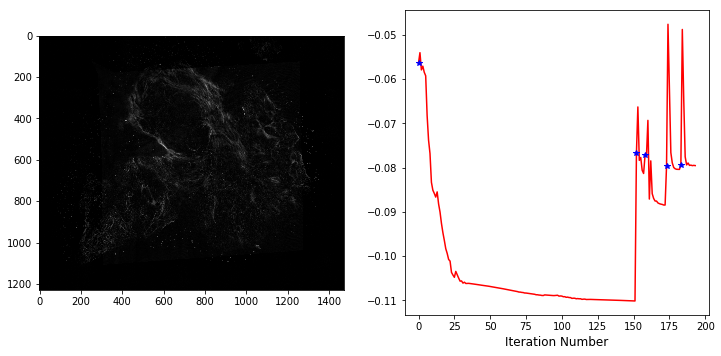

Final metric value: -0.0795265247319142
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 11 iterations. Gradient magnitude (9.3355e-05) is less than gradient magnitude tolerance (0.0001).
itk::simple::Transform
 AffineTransform (00000280F5592700)
   RTTI typeinfo:   class itk::AffineTransform<double,2>
   Reference Count: 3
   Modified Time: 28459470
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.99889 -0.0142492 
     0.0145464 0.993351 
   Offset: [28.5169, 56.7266]
   Center: [0, 0]
   Translation: [28.5169, 56.7266]
   Inverse: 
     1.0009 0.0143575 
     -0.0146569 1.00648 
   Singular: 0



In [18]:

#For WP4, WP5 and WP9, the start is so far off we need to fix origin for registration. WP4[1000, 652] WP5 [2500, 2000], WP9 [2600,2600]
moving.SetOrigin([1000,652])

(transform, metric, stop) = affine_registration(fixed, moving)
print('Final metric value: {0}'.format(metric))
print('Optimizer\'s stopping condition, {0}'.format(stop))
print(transform)
#print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
#print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))


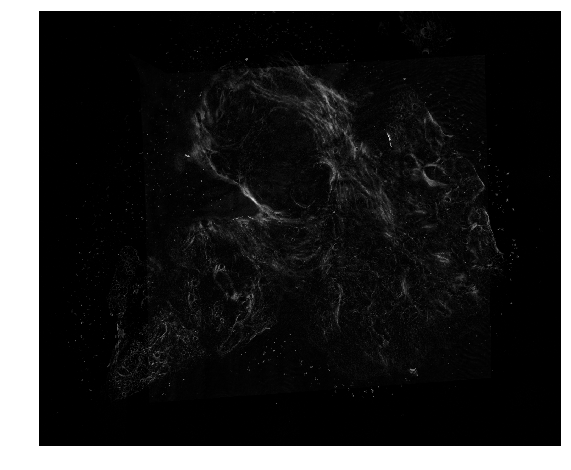

In [19]:
registered = sitk.Resample(moving, fixed, transform, sitk.sitkLinear, 0.0, moving.GetPixelID())
display_images_with_alpha(0.7,fixed, registered)


In [20]:
#maskedFixed = sitk.Mask(fixed,fixedMask)
postRegMask = registered > 0
masked_fixed_image = sitk.Mask(fixed,postRegMask)
#myshow(masked_fixed_image)

In [21]:
sitk.WriteImage(registered,os.path.join(OutDir,sample+'_RegularStepAffineReg'+'.tif'))

In [22]:
sitk.WriteImage(masked_fixed_image,os.path.join(OutDir,sample+'_maskFix_RegularStepAffineReg'+'.tif'))

## Second registration

This is a second fine-tuning registration.  Some of the registration results need a second pass

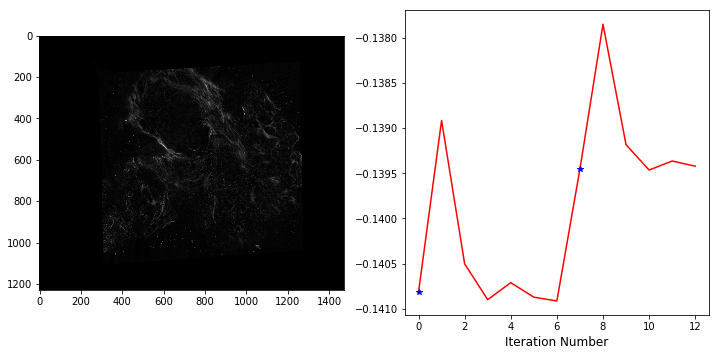

Final metric value: -0.13946108269258595
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 6 iterations. Gradient magnitude (9.60511e-05) is less than gradient magnitude tolerance (0.0001).
itk::simple::Transform
 AffineTransform (00000280F5592700)
   RTTI typeinfo:   class itk::AffineTransform<double,2>
   Reference Count: 3
   Modified Time: 28459470
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.99889 -0.0142492 
     0.0145464 0.993351 
   Offset: [28.5169, 56.7266]
   Center: [0, 0]
   Translation: [28.5169, 56.7266]
   Inverse: 
     1.0009 0.0143575 
     -0.0146569 1.00648 
   Singular: 0



In [23]:
(transform2, metric2, stop2) = affine_registration_fineRegister(masked_fixed_image, registered)
print('Final metric value: {0}'.format(metric2))
print('Optimizer\'s stopping condition, {0}'.format(stop2))
print(transform)

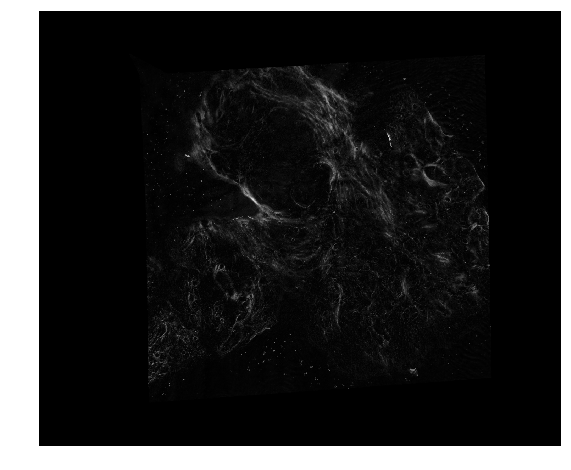

In [24]:
registered2 = sitk.Resample(registered, masked_fixed_image, transform2, sitk.sitkLinear, 0.0, moving.GetPixelID())

display_images_with_alpha(0.7,masked_fixed_image, registered2)


In [25]:
sitk.WriteImage(registered2,os.path.join(OutDir,sample+'_RegularStepAffineReg_RegToMask'+'.tif'))

# WP5

In [26]:
sample = 'WP5'

fixed = polToDegree(sitk.ReadImage(PolDir + sample + '.tif', sitk.sitkFloat32),35)
moving = sitk.ReadImage(MMPDir + sample + '_MMP.tif')


# All polscope images 
fixed.SetSpacing([5.416,5.416])


#For WP2, WP5, WP9
#moving.SetSpacing([5.78,5.78])

#For WP4
moving.SetSpacing([5.72,5.72])


#moving.SetOrigin([3480,1698])
# fixed.SetOrigin([4284,2205])


## Display initial image pairs

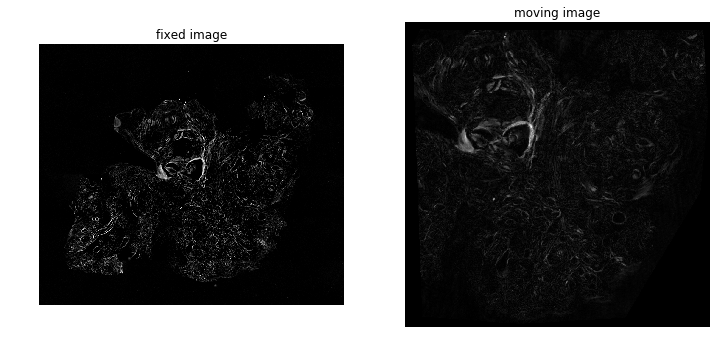

In [27]:
display_images(fixed, moving)

## Affine Registration

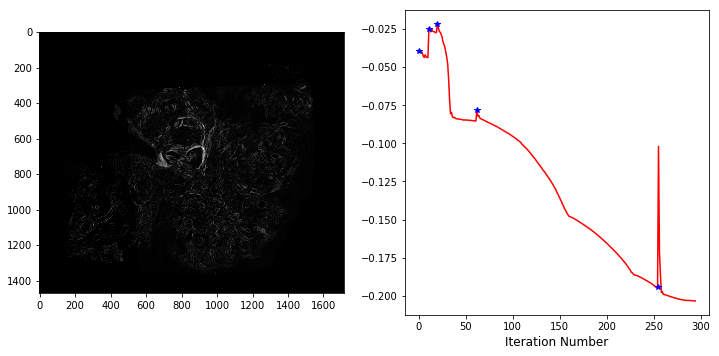

Final metric value: -0.20338137607094453
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 41 iterations. Gradient magnitude (9.61807e-05) is less than gradient magnitude tolerance (0.0001).
itk::simple::Transform
 AffineTransform (00000280F5595680)
   RTTI typeinfo:   class itk::AffineTransform<double,2>
   Reference Count: 3
   Modified Time: 51012238
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.992381 -0.045624 
     0.0416502 0.99018 
   Offset: [115.093, 251.917]
   Center: [0, 0]
   Translation: [115.093, 251.917]
   Inverse: 
     1.00573 0.0463407 
     -0.0423044 1.00797 
   Singular: 0



In [28]:

#For WP4, WP5 and WP9, the start is so far off we need to fix origin for registration. WP4[1000, 652] WP5 [2500, 2000], WP9 [2600,2600]
moving.SetOrigin([2500,2000])

(transform, metric, stop) = affine_registration(fixed, moving)
print('Final metric value: {0}'.format(metric))
print('Optimizer\'s stopping condition, {0}'.format(stop))
print(transform)
#print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
#print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))


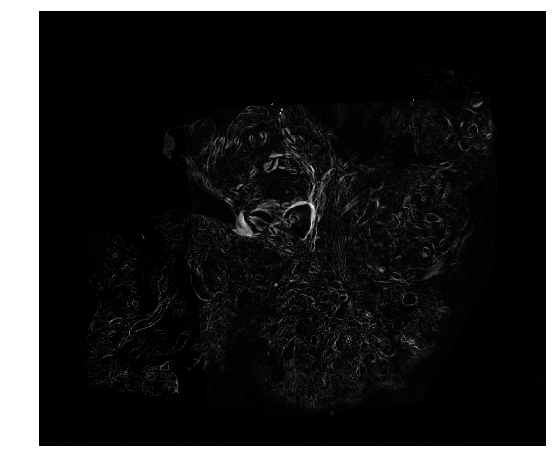

In [29]:
registered = sitk.Resample(moving, fixed, transform, sitk.sitkLinear, 0.0, moving.GetPixelID())
display_images_with_alpha(0.7,fixed, registered)


In [30]:
#maskedFixed = sitk.Mask(fixed,fixedMask)
postRegMask = registered > 0
masked_fixed_image = sitk.Mask(fixed,postRegMask)
#myshow(masked_fixed_image)

In [31]:
sitk.WriteImage(registered,os.path.join(OutDir,sample+'_RegularStepAffineReg'+'.tif'))

In [32]:
sitk.WriteImage(masked_fixed_image,os.path.join(OutDir,sample+'_maskFix_RegularStepAffineReg'+'.tif'))

## Second registration

This is a second fine-tuning registration.  Some of the registration results need a second pass

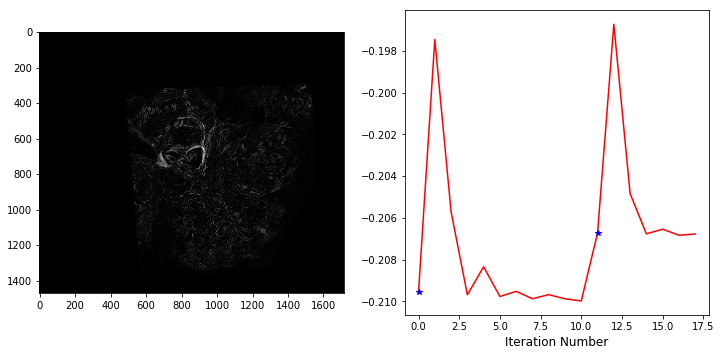

Final metric value: -0.20684409975380455
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 7 iterations. Gradient magnitude (8.85198e-05) is less than gradient magnitude tolerance (0.0001).
itk::simple::Transform
 AffineTransform (00000280F5595680)
   RTTI typeinfo:   class itk::AffineTransform<double,2>
   Reference Count: 3
   Modified Time: 51012238
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.992381 -0.045624 
     0.0416502 0.99018 
   Offset: [115.093, 251.917]
   Center: [0, 0]
   Translation: [115.093, 251.917]
   Inverse: 
     1.00573 0.0463407 
     -0.0423044 1.00797 
   Singular: 0



In [33]:
(transform2, metric2, stop2) = affine_registration_fineRegister(masked_fixed_image, registered)
print('Final metric value: {0}'.format(metric2))
print('Optimizer\'s stopping condition, {0}'.format(stop2))
print(transform)

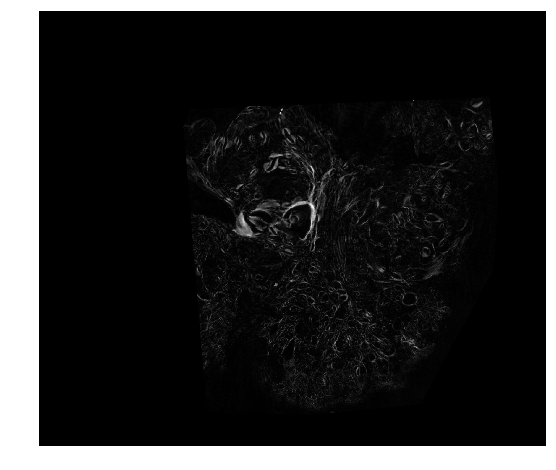

In [34]:
registered2 = sitk.Resample(registered, masked_fixed_image, transform2, sitk.sitkLinear, 0.0, moving.GetPixelID())

display_images_with_alpha(0.7,masked_fixed_image, registered2)


In [35]:
sitk.WriteImage(registered2,os.path.join(OutDir,sample+'_RegularStepAffineReg_RegToMask'+'.tif'))

# WP9

In [36]:
sample = 'WP9'

fixed = polToDegree(sitk.ReadImage(PolDir + sample + '.tif', sitk.sitkFloat32),35)
moving = sitk.ReadImage(MMPDir + sample + '_MMP.tif')


# All polscope images 
fixed.SetSpacing([5.416,5.416])


#For WP2, WP5, WP9
moving.SetSpacing([5.78,5.78])

#For WP4
#moving.SetSpacing([5.72,5.72])


#moving.SetOrigin([3480,1698])
# fixed.SetOrigin([4284,2205])


## Display initial image pairs

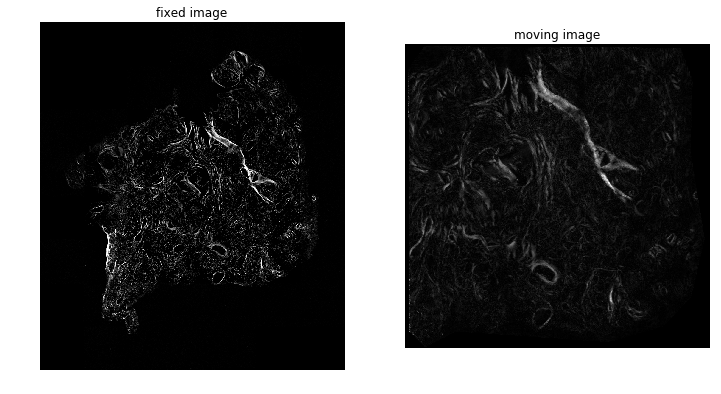

In [37]:
display_images(fixed, moving)

## Affine Registration

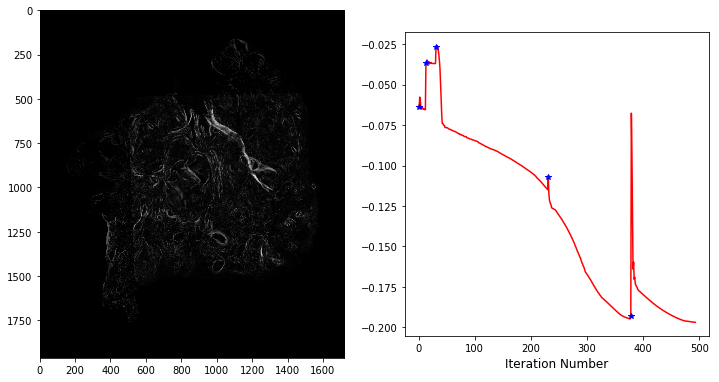

Final metric value: -0.1969728137515454
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 116 iterations. Gradient magnitude (9.83887e-05) is less than gradient magnitude tolerance (0.0001).
itk::simple::Transform
 AffineTransform (00000280F5596580)
   RTTI typeinfo:   class itk::AffineTransform<double,2>
   Reference Count: 3
   Modified Time: 81713327
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1.004 -0.0305016 
     0.030063 1.00093 
   Offset: [36.5652, -78.7326]
   Center: [0, 0]
   Translation: [36.5652, -78.7326]
   Inverse: 
     0.995112 0.0303244 
     -0.0298884 0.998162 
   Singular: 0



In [38]:

#For WP4, WP5 and WP9, the start is so far off we need to fix origin for registration. WP2[1000, 652] WP5 [2500, 2000], WP9 [2600,2600]
moving.SetOrigin([2600,2600])

(transform, metric, stop) = affine_registration(fixed, moving)
print('Final metric value: {0}'.format(metric))
print('Optimizer\'s stopping condition, {0}'.format(stop))
print(transform)
#print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
#print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))


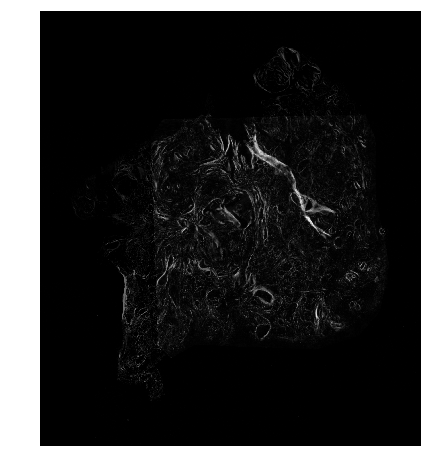

In [39]:
registered = sitk.Resample(moving, fixed, transform, sitk.sitkLinear, 0.0, moving.GetPixelID())
display_images_with_alpha(0.7,fixed, registered)


In [40]:
#maskedFixed = sitk.Mask(fixed,fixedMask)
postRegMask = registered > 0
masked_fixed_image = sitk.Mask(fixed,postRegMask)
#myshow(masked_fixed_image)

In [41]:
sitk.WriteImage(registered,os.path.join(OutDir,sample+'_RegularStepAffineReg'+'.tif'))

In [42]:
sitk.WriteImage(masked_fixed_image,os.path.join(OutDir,sample+'_maskFix_RegularStepAffineReg'+'.tif'))

## Second registration

This is a second fine-tuning registration.  Some of the registration results need a second pass

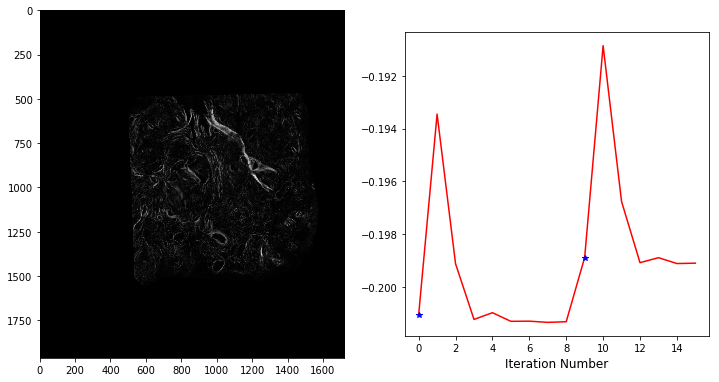

Final metric value: -0.19910997500002375
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 7 iterations. Gradient magnitude (8.14646e-05) is less than gradient magnitude tolerance (0.0001).
itk::simple::Transform
 AffineTransform (00000280F5596580)
   RTTI typeinfo:   class itk::AffineTransform<double,2>
   Reference Count: 3
   Modified Time: 81713327
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1.004 -0.0305016 
     0.030063 1.00093 
   Offset: [36.5652, -78.7326]
   Center: [0, 0]
   Translation: [36.5652, -78.7326]
   Inverse: 
     0.995112 0.0303244 
     -0.0298884 0.998162 
   Singular: 0



In [43]:
(transform2, metric2, stop2) = affine_registration_fineRegister(masked_fixed_image, registered)
print('Final metric value: {0}'.format(metric2))
print('Optimizer\'s stopping condition, {0}'.format(stop2))
print(transform)

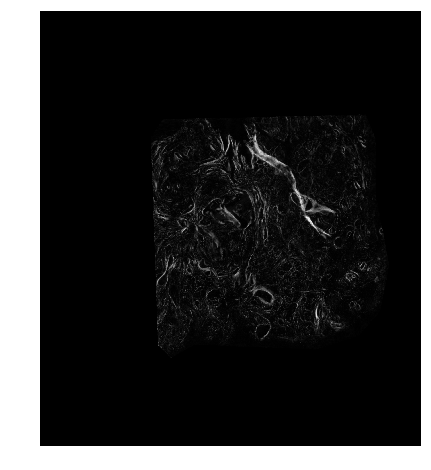

In [44]:
registered2 = sitk.Resample(registered, masked_fixed_image, transform2, sitk.sitkLinear, 0.0, moving.GetPixelID())

display_images_with_alpha(0.7,masked_fixed_image, registered2)


In [45]:
sitk.WriteImage(registered2,os.path.join(OutDir,sample+'_RegularStepAffineReg_RegToMask'+'.tif'))